In [119]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
%matplotlib inline
def process_unis():
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
        
    return unis

def process_completions(year):
    completions = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
    return completions
# hard coded it because of assignment errors

In [2]:
def startup():
    all_unis = {}
    all_completions = {}
    for year in range(2008, 2022):
        all_unis[year] = process_unis()
        all_completions[year] = process_completions(year)
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, cols

In [3]:
def region_processing(uni_data, completion_data, region):
    uni_boolmap = uni_data['OBEREG'] == region
    region_unis = uni_data[uni_boolmap]
    unitids = set(region_unis['UNITID'])
    completion_boolmap = completion_data['UNITID'].apply(lambda x: x in unitids)
    region_data = completion_data[completion_boolmap]
    return region_data, region_unis

In [4]:
reg_code_to_label = {0: 'US Service Schools', 1: 'New England', 2: 'Mid East', 3: 'Great Lakes', 4: 'Plains',\
     5: 'Southeast',6: 'Southwest', 7: 'Rocky Mountains',8: 'Far West', 9: 'Outlying Areas'}

In [16]:
def make_years(completions, unis, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = unis[year], completions[year]
        years[year] = [year_completions, year_unis]
    return years

In [26]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        unis, data = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge['year'] = year
        nonCsMerge['year'] = year
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [7]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    nonCs = nonCs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [30]:
def cs_nonCs_difference(cs, nonCs):
    cs = cs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    nonCs = nonCs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    difference = cs - nonCs
    difference.columns = ['d_%s' % col for col in difference.columns]
        
    difference = difference.reset_index()
    return difference

In [44]:
def get_avg(data):
    data = data.groupby('UNITID').mean()
    return data.reset_index()

In [113]:
def make_correlation_df(data, unis, demo):
    correlation_df_merge = pd.merge(data[['UNITID', 'd_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], unis, on='UNITID')
    non_differences = correlation_df_merge.drop(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT'], axis=1)
    correlations_df = non_differences.corrwith(correlation_df_merge[demo])
    #correlations_df = correlation_df_merge[['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']].corrwith(non_differences, axis=0)
    return correlations_df.dropna()
    


In [109]:
def average():
    all_unis, all_completions, cols = startup()
    years = make_years(all_completions, all_unis, 2008, 2021)
    cs_group, nonCs_group = groupTotals(years)
    cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
    difference = cs_nonCs_difference(cs_percent, nonCs_percent)
    average = get_avg(difference)
    maxes = {}
    demos = ['women', 'black', 'hispanic', 'natives']
    for i, demo in enumerate(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']):
        corr = make_correlation_df(average, all_unis[2021], demo)
        maxes[demos[i]]  = [corr.idxmin(), corr.idxmax()]
    return maxes

In [110]:
def by_year(year):
    all_unis, all_completions, cols = startup()
    years = make_years(all_completions, all_unis, year, year)
    cs_group, nonCs_group = groupTotals(years)
    cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
    difference = cs_nonCs_difference(cs_percent, nonCs_percent)
    maxes = {}
    demos = ['women', 'black', 'hispanic', 'natives']
    for i, demo in enumerate(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']):
        corr = make_correlation_df(difference, all_unis[year], demo)
        maxes[demos[i]]  = [corr.idxmin(), corr.idxmax()]
    return maxes

In [111]:
average = average()
average

{'women': ['C21IPGRD', 'HBCU'],
 'black': ['C21IPGRD', 'HBCU'],
 'hispanic': ['C21IPGRD', 'HBCU'],
 'natives': ['C21IPGRD', 'HBCU']}

In [112]:
year = by_year(2021)
year

{'women': ['C21IPGRD', 'CARNEGIE'],
 'black': ['C21IPGRD', 'CARNEGIE'],
 'hispanic': ['C21IPGRD', 'CARNEGIE'],
 'natives': ['C21IPGRD', 'CARNEGIE']}

In [ ]:
years = {}
for year in range(2008, 2021)

In [114]:
all_unis, all_completions, cols = startup()
years = make_years(all_completions, all_unis, 2008, 2021)
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
difference = cs_nonCs_difference(cs_percent, nonCs_percent)
average = get_avg(difference)


In [116]:
corr = pd.merge(average[['UNITID', 'd_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], all_unis[2021], on='UNITID')

In [124]:
corr.dtypes

UNITID         int64
d_CTOTALW    float64
d_CBKAAT     float64
d_CHISPT     float64
d_CAIANT     float64
              ...   
CNGDSTCD       int64
LONGITUD     float64
LATITUDE     float64
DFRCGID        int64
DFRCUSCG       int64
Length: 78, dtype: object

In [121]:
corr_df = corr.corr()

<AxesSubplot:>

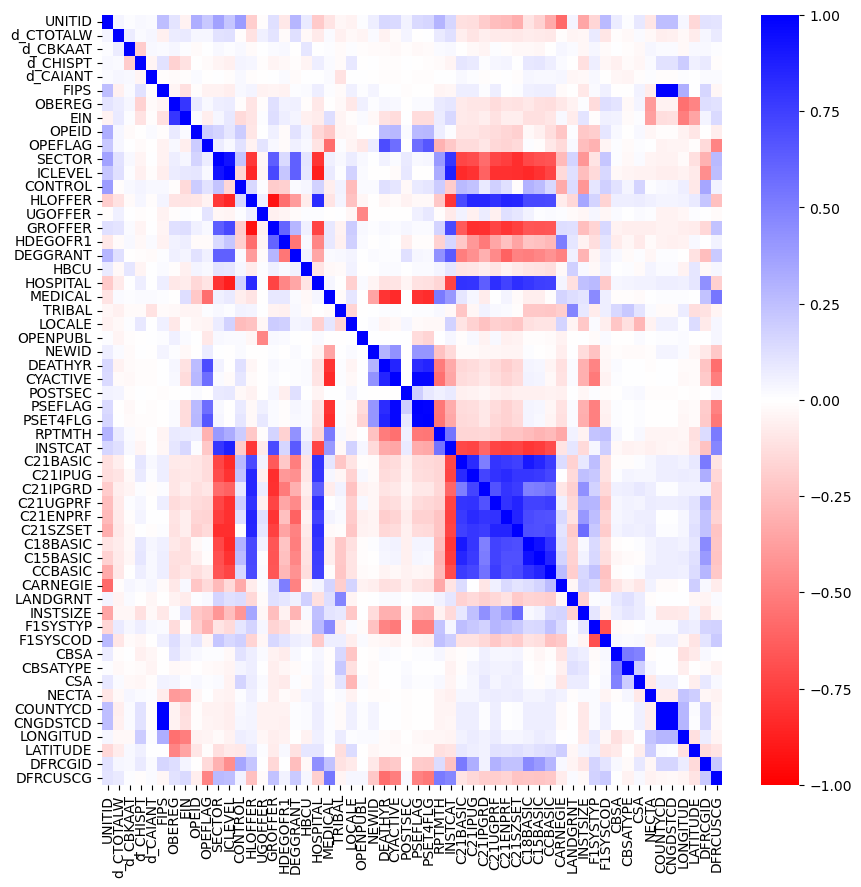

In [135]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.index, vmin=-1, vmax=1, cmap='bwr_r')

In [140]:
corr_df.loc['d_CTOTALW'].sort_values()

HLOFFER     -0.109558
C21IPUG     -0.108279
F1SYSCOD    -0.098067
C21SZSET    -0.089723
CCBASIC     -0.088311
C21ENPRF    -0.083337
C21UGPRF    -0.082339
HOSPITAL    -0.082312
C15BASIC    -0.078344
C18BASIC    -0.077556
LATITUDE    -0.074981
C21IPGRD    -0.064894
C21BASIC    -0.064561
COUNTYCD    -0.062571
CNGDSTCD    -0.062072
FIPS        -0.057115
TRIBAL      -0.056692
DEATHYR     -0.047845
OPENPUBL    -0.046539
LANDGRNT    -0.042471
INSTSIZE    -0.037494
NECTA       -0.030830
LOCALE      -0.028050
CBSATYPE    -0.026128
LONGITUD    -0.024861
HBCU        -0.023578
CYACTIVE    -0.018394
HDEGOFR1    -0.016220
CARNEGIE    -0.013288
CONTROL     -0.013210
CBSA        -0.012589
PSEFLAG     -0.003216
PSET4FLG     0.001522
MEDICAL      0.016672
NEWID        0.016711
d_CHISPT     0.020280
CSA          0.022361
OPEFLAG      0.031372
OPEID        0.032411
DFRCGID      0.034435
d_CAIANT     0.036732
UNITID       0.041434
POSTSEC      0.042238
UGOFFER      0.056432
OBEREG       0.071965
d_CBKAAT  